# Imports and preparation

In [1]:
import os

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
from tqdm import tqdm

In [5]:
import time, gc

In [6]:
import importlib

In [7]:
from itertools import product


In [8]:
from util import util_elastic

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


In [9]:
from util import util_pipeline_v2 as util_pipeline

In [10]:
from util import util_experiment_juris_tcu_index  as util_experiment

In [11]:
# Para ter repetibilidade nos resultados
random_state = 1

# Tratar valores infinitos (+ e -) como np.NaN
pd.options.mode.use_inf_as_na = True

# IMPORTANTE para tornar figuras interativas
# %matplotlib notebook

# Tamanho padrão das figuras
figsize=(10,6)

pd.set_option('display.max_row', 1000)

pd.set_option('display.max_columns', 50)

pd.set_option('display.column_space', 40)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 200)


In [12]:
PATH_QUERY = '../data/juris_tcu_index/query.csv'
PATH_QREL =  '../data/juris_tcu_index/qrel.csv'

# Data load

## Query data load

In [13]:
df_query = pd.read_csv(PATH_QUERY)

In [14]:
df_query.shape

(16045, 11)

In [15]:
df_query[df_query['ID']==2845]

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
5618,2845,"Em regra, o pregão é a modalidade de licitação adequada para a concessão remunerada de uso de be...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 478/2016 - Plenário,2016-03-02,RELATOR,MARCOS BEMQUERER


In [16]:
df_query.head()

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
0,13568,"É ilegal a contagem de tempo ficto de serviço prestado sob a égide da Lei 3.313/1957, proporcion...",Lei Complementar 51/1985 || Lei Ordinária 3313/1957,NaN,Pessoal,1131,APOSENTADORIA,Acórdão 168/2014 - Segunda Câmara,2014-01-28,RELATOR,JOSÉ JORGE
1,11614,"SÚMULA TCU 283: Para fim de habilitação, a Administração Pública não deve exigir dos licitantes ...",NaN,SUMULA,Licitação,932,ADMINISTRATIVO,Acórdão 1613/2013 - Plenário,2013-06-26,RELATOR,JOSÉ JORGE
2,21087,"A contratação de serviços por preços superiores às referências legais (Sinapi e Sicro) deve ser,...",NaN,NaN,Licitação,932,PRESTAÇÃO DE CONTAS,Acórdão 3936/2013 - Segunda Câmara,2013-07-09,RELATOR,ANA ARRAES
3,35016,"Não se aplica, excepcionalmente, multa aos gestores por grave infração à norma legal se a irregu...",NaN,NaN,Responsabilidade,775,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ
4,29370,"Em contratatações de TI, não cabe aceitar propostas de preço com incidência de encargos majorado...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ


## Qrel data load

In [17]:
df_qrel = pd.read_csv(PATH_QREL)

In [18]:
df_qrel.shape

(94809, 3)

In [19]:
df_qrel.head()

,QUERY_ID,DOC_ID,TYPE
0,158,15147,INDEXACAO_EXTRA
1,37,15147,INDEXACAO_EXTRA
2,178,15147,INDEXACAO_EXTRA
3,14564,15147,INDEXACAO_EXTRA
4,9219,15147,INDEXACAO_EXTRA


In [20]:
df_qrel.shape[0]

94809

In [21]:
df_search_data = df_query.merge(df_qrel, how='left', left_on='ID', right_on='QUERY_ID').drop('QUERY_ID', axis=1)

In [22]:
df_search_data.shape[0]


94809

In [23]:
# Agrupar os dados pelo ID e criar a coluna 'RELEVANCE_LIST' com a lista de tuplas
# df_new = df_search_data.groupby('ID').apply(lambda x: list(zip(x['DOC_ID'], x['TYPE']))).reset_index(name='RELEVANCE_LIST')
# df_new['RELEVANCE_LIST'] = df_new['RELEVANCE_LIST'].apply(lambda x: sorted(x, key=lambda tup: ('AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA').index(tup[1])))
df_new = df_search_data.groupby('ID').apply(lambda x: dict(zip(x['DOC_ID'], x['TYPE']))).reset_index(name='RELEVANCE_DICT')


In [24]:
df_new.head()

,ID,RELEVANCE_DICT
0,5,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,6,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,7,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,8,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,9,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [25]:
# Unir o resultado com as demais colunas únicas
df_new = pd.merge(df_new, df_search_data.drop_duplicates('ID'), on='ID', how='left')

In [26]:

# Selecionar as colunas desejadas
df_search_data = df_new[['ID', 'TEXT', 'REFERENCE_LIST', 'PARADIGMATIC', 'AREA_NAME', 'AREA_ID_DESCRIPTOR', 'NORMATIVE_PROCESS_TYPE', 'NORMATIVE_IDENTIFICATION', 'NORMATIVE_DATE', 'NORMATIVE_AUTHOR_TYPE', 'NORMATIVE_AUTHOR_NAME', 'RELEVANCE_DICT']]


In [27]:
df_search_data.shape

(16045, 12)

In [28]:
df_search_data = df_search_data.reset_index()

In [29]:
df_search_data.head()

,index,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME,RELEVANCE_DICT
0,0,5,"SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial co...","Lei Ordinária 3738/1960 || Lei Ordinária 1711/1952, art. 184",SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,1,6,"SÚMULA TCU 2: Configura-se como vencimento, para efeito da concessão da pensão especial com fund...",Lei Ordinária 3738/1960,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,2,7,SÚMULA TCU 3: O arquivamento é a solução indicada para as hipóteses em que as contas de responsá...,NaN,SUMULA,Direito processual,5288,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,3,8,"SÚMULA TCU 4: A reclassificação de cargos não aproveita ao servidor aposentado, a menos que lei ...",NaN,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,4,9,"SÚMULA TCU 5 (REVOGADA): As sociedades de economia mista, salvo disposição expressa em lei, não ...",NaN,SUMULA,Competência do TCU,5095,NaN,AC 2082/2007-PL,2007-10-03,RELATOR,UBIRATAN AGUIAR,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [30]:
del df_new

# Create reference to index (elastic search)

Documentation https://docs.haystack.deepset.ai/docs
https://haystack.deepset.ai/tutorials/09_dpr_training 


In [31]:
index_dict = util_elastic.return_indexes('indir', parm_print=True)

Index: indir_juris_tcu
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu', 'uuid': 'RD_aAWppQH6vjNxKUdL_0w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '334.9mb', 'pri.store.size': '334.9mb'}

Index: indir_juris_tcu_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_term', 'uuid': 'S5WlNGiqSXC-79WaqfsddA', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '337.5mb', 'pri.store.size': '337.5mb'}

Index: indir_juris_tcu_synonym_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_synonym_related_term', 'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '3045', 'store.size': '348.4mb', 'pri.store.size': '348.4mb'}

Index: indir_juris_tcu_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_related_term', 'uuid': 'i9nzlBQrREyEC7MGT79GBQ', 'pri': '1', 'rep': '1', 'docs.count': '16045',

In [32]:
index_dict

{'indir_juris_tcu': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu',
  'uuid': 'RD_aAWppQH6vjNxKUdL_0w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '334.9mb',
  'pri.store.size': '334.9mb'},
 'indir_juris_tcu_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_term',
  'uuid': 'S5WlNGiqSXC-79WaqfsddA',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '337.5mb',
  'pri.store.size': '337.5mb'},
 'indir_juris_tcu_synonym_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_synonym_related_term',
  'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '3045',
  'store.size': '348.4mb',
  'pri.store.size': '348.4mb'},
 'indir_juris_tcu_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_related_term',
  'uuid': 'i9nzlBQrREyEC7MGT79GBQ'

In [33]:
INDEX_NAME = 'indir_juris_tcu_index'

In [34]:
index = util_elastic.return_index(parm_index_name=INDEX_NAME)


Qtd de documentos 13255

Qtd de embeddings 13255

Documento.id=5: <Document: id=5, content='O termo é "Abono de permanência em serviço".
Abono de permanência em serviço tem definição: "O abono...'>


# Pipelines creation

In [35]:
pipes = []

In [38]:
# Test query
# parm_query = "trata-se de uma denúncia contra o prefeito de Manhuaçu por não haver pago os funcionários da área de limpeza urbana"
parm_query = "A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou."

In [39]:
raise Exception ('Stop execution - create only desired pipelines in code below ')

Exception: Stop execution - create only desired pipelines in code below 

In [40]:
pipes

[]

## Only retrievers

### join

#### sts + bm25

In [ ]:
%%time
pipe_join_sts_bm25 = util_pipeline.return_pipeline_join_bm25_sts(index)

CPU times: user 3.01 s, sys: 568 ms, total: 3.58 s
Wall time: 1.98 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_join_sts_bm25',
              'PIPE_OBJECT': pipe_join_sts_bm25,
              'RETRIEVER_TYPE': 'join_sts_bm25',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_join_sts_bm25.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 300}, "StsRetriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Bm25Retriever': {'top_k': 300}, 'StsRetriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 542
Primeiro docto:
<Document: id=1102005, content='O termo é "Plano de contratações".
Plano de contratações tem definição: "É o documento no qual a org...'>

Último (542):
<Document: id=1103641, content='O termo é "Falta grave".
Falta grave tem nota de escopo: "Está prevista em várias normatizações que ...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Plano de contratações', '1102005', 0.981894035831847]
1 : ['Competência do TCU', '5095', 0.981022770821533]
2 : ['Nexo de causalidade', '4495', 0.9782476752974565]
3 : ['Teletrabalho', '5949', 0.977450618284214]
4 : ['Papéis de trabalho', '15181', 0.976140477988525]
5

#### sts_multihop + bm25

In [ ]:
%%time
pipe_join_sts_multihop_bm25 = util_pipeline.return_pipeline_join_bm25_sts_multihop(index)

CPU times: user 3.36 s, sys: 674 ms, total: 4.04 s
Wall time: 2.12 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_join_sts_multihop_bm25',
              'PIPE_OBJECT': pipe_join_sts_multihop_bm25,
              'RETRIEVER_TYPE': 'join_sts_multihop_bm25',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_join_sts_multihop_bm25.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 150}, "StsRetriever": {"top_k": 150}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Bm25Retriever': {'top_k': 150}, 'StsRetriever': {'top_k': 150}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 289
Primeiro docto:
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>

Último (289):
<Document: id=1102397, content='O termo é "Estado de exceção".
Estado de exceção tem nota de escopo: "Situação oposta ao Estado demo...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Afastamento de responsável', 0.9930839884285582]
1 : ['Plano de contratações', 0.9856940203493179]
2 : ['Competência do TCU', 0.9849874794705751]
3 : ['Teletrabalho', 0.9823437136689326]
4 : ['Nexo de causalidade', 0.982157658932855]
5 : ['Processo administrativo de resp

### sts_multihop

In [ ]:
%%time
pipe_sts_multihop = util_pipeline.return_pipeline_sts_multihop(index)

CPU times: user 3.39 s, sys: 715 ms, total: 4.11 s
Wall time: 2.16 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts_multihop',
              'PIPE_OBJECT': pipe_sts_multihop,
              'RETRIEVER_TYPE': 'sts_multihop',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_sts_multihop.run(query=parm_query, 
 params={"Retriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 300
Primeiro docto:
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>

Último (300):
<Document: id=2550, content='O termo é "Declaração de nulidade".
Declaração de nulidade tem definição: "Declaração que torna o co...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Afastamento de responsável', 0.9930839884285582]
1 : ['Rescisão unilateral', 0.9748706914060489]
2 : ['Afastamento preventivo', 0.9741557736812957]
3 : ['Perda de objeto', 0.9725962719359168]
4 : ['Abandono de cargo', 0.9696305808093489]
5 : ['Responsabilidade perante o controle externo', 0.9692663708644913]


### sts

In [ ]:
%%time
pipe_sts = util_pipeline.return_pipeline_sts(index)

CPU times: user 3.39 s, sys: 656 ms, total: 4.05 s
Wall time: 2.1 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts',
              'PIPE_OBJECT': pipe_sts,
              'RETRIEVER_TYPE': 'sts',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_sts.run(query=parm_query, 
 params={"Retriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 300
Primeiro docto:
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>

Último (300):
<Document: id=1103641, content='O termo é "Falta grave".
Falta grave tem nota de escopo: "Está prevista em várias normatizações que ...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Afastamento de responsável', '2577', 0.9546168861748239]
1 : ['Risco de controle', '1101311', 0.943127201770828]
2 : ['Vazamento de dados', '1110487', 0.942404112002669]
3 : ['Trancamento das contas', '2663', 0.9341491636096659]
4 : ['Revisão de ofício', '15291', 0.9297291992714615]
5 : ['Responsabilidade 

### bm25

In [ ]:
%%time
pipe_bm25 = util_pipeline.return_pipeline_bm25(index)

CPU times: user 268 µs, sys: 0 ns, total: 268 µs
Wall time: 273 µs


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_bm25',
              'PIPE_OBJECT': pipe_bm25,
              'RETRIEVER_TYPE': 'bm25', 
              'RETRIEVER_MODEL_NAME': '', # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_bm25.run(query=parm_query, 
 params={"Retriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 300
Primeiro docto:
<Document: id=1102005, content='O termo é "Plano de contratações".
Plano de contratações tem definição: "É o documento no qual a org...'>

Último (300):
<Document: id=6150, content='O termo é "Gestão de risco".
Gestão de risco tem definição: "Identificar, analisar e eliminar, se po...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Plano de contratações', '1102005', 0.981894035831847]
1 : ['Competência do TCU', '5095', 0.981022770821533]
2 : ['Nexo de causalidade', '4495', 0.9782476752974565]
3 : ['Teletrabalho', '5949', 0.977450618284214]
4 : ['Evidência documental', '1101364', 0.9766837588293696]
5 : ['Processo administrativo de re

## With rankers

In [41]:
ranker_type = 'PTT5_INDIR_5200' # 'MINILM_INDIR' # 'MT5_3B' # 'MT5_TRAINED_LIM50_800' # 'MINILM_TRAINED_19000'

In [42]:
importlib.reload(util_pipeline)

<module 'util.util_pipeline_v2' from '/home/borela/fontes/ind-ir/code/util/util_pipeline_v2.py'>

### First stage = sts_multihop

In [ ]:
importlib.reload(util_experiment)

<module 'util.util_search' from '/home/borela/fontes/ind-ir/code/util/util_search.py'>

In [ ]:
%%time
pipe_sts_multihop_ranker_monot5_3b = util_pipeline.return_pipeline_sts_multihop_reranker(index, 'MONOT5', parm_limit_query_size=350)

CPU times: user 39.1 s, sys: 7.6 s, total: 46.7 s
Wall time: 36.4 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts_multihop_ranker_monot5_3b',
              'PIPE_OBJECT': pipe_sts_multihop_ranker_monot5_3b,
              'RETRIEVER_TYPE': 'sts_multihop',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': util_pipeline.nome_modelo_monot5_3b})

In [ ]:
%%time
doctos_retornados_ranker = pipe_sts_multihop_ranker_monot5_3b.run(query=parm_query, params= {'Retriever': {'filters':{'class':['Termo']}}}) 
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'filters': {'class': ['Termo']}}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Primeiro docto:
<Document: id=5098, content='O termo é "Responsabilidade perante o controle externo".
Responsabilidade perante o controle externo...'>

Último (10):
<Document: id=5450, content='O termo é "Dispensa sem justa causa".
Dispensa sem justa causa tem definição: "Art. 477.  Na extinçã...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Responsabilidade perante o controle externo', -0.29318735003471375]
1 : ['Afastamento de responsável', -0.8160551190376282]
2 : ['Descarte de documentos', -1.4474653005599976]
3 : ['Excludente de responsabilidade', -2.6080782413482666]
4 : ['Perda de objeto', -2.8628034591674805]
5 : ['Afasta

### First stage = Join bm25 + sts

In [ ]:
import importlib
importlib.reload(util_experiment)

<module 'util.util_experiment_juris_tcu_index' from '/home/borela/fontes/ind-ir/code/util/util_experiment_juris_tcu_index.py'>

In [ ]:
%%time
pipe_join_bm25_sts_reranker = util_pipeline.return_pipeline_join_bm25_sts_reranker(index, ranker_type, parm_limit_query_size=350)

Loading MINILM_TRAINED_49200 with limit_query_size=350
CPU times: user 10.3 s, sys: 2.04 s, total: 12.3 s
Wall time: 6.77 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_join_bm25_sts_reranker',
              'PIPE_OBJECT': pipe_join_bm25_sts_reranker,
              'RETRIEVER_TYPE': 'join_sts_bm25',  
              'RETRIEVER_MODEL_NAME': '', 
              'RANKER_MODEL_NAME': util_pipeline.return_ranker_name(ranker_type)})

In [ ]:
%%time
doctos_retornados_ranker = pipe_join_bm25_sts_reranker.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 300}, "StsRetriever": {"top_k": 300}, "Ranker": {"top_k": 10}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

### First stage = BM25

In [43]:
%%time
pipe_bm25_ranker = util_pipeline.return_pipeline_bm25_reranker(index, ranker_type, parm_limit_query_size=350)

Loading PTT5_INDIR_5200 with limit_query_size=350
CPU times: user 7.97 s, sys: 1.55 s, total: 9.52 s
Wall time: 6.51 s


In [44]:
pipes.append({'PIPE_NAME': 'pipe_bm25_ranker',
              'PIPE_OBJECT': pipe_bm25_ranker,
              'RETRIEVER_TYPE': 'bm25',  
              'RETRIEVER_MODEL_NAME': '', 
              'RANKER_MODEL_NAME': util_pipeline.return_ranker_name(ranker_type)})

In [45]:
doctos_retornados_ranker = pipe_bm25_ranker.run(query=parm_query)
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Competência do TCU', '5095', -0.13800208270549774]
1 : ['Nexo de causalidade', '4495', -0.18137602508068085]
2 : ['Papéis de trabalho', '15181', -1.0923926830291748]
3 : ['Evidência documental', '1101364', -1.6396220922470093]
4 : ['Julgamento de contas', '874', -3.0505428314208984]
5 : ['Processo administrativo de responsabilização', '1104189', -3.3401060104370117]
6 : ['Ofício de requisição', '1101404', -3.5084125995635986]
7 : ['Matriz de fiscalização', '6627', -3.9182260036468506]
8 : ['Teletrabalho', '5949', -5.3566412925720215]
9 : ['Plano de contratações', '1102005', -8.301259994506836]


### First stage = Sentence Similarity

In [ ]:
%%time
pipe_sts_ranker = util_pipeline.return_pipeline_sts_reranker(index, ranker_type, parm_limit_query_size=350)

CPU times: user 3.18 s, sys: 538 ms, total: 3.72 s
Wall time: 1.97 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts_ranker',
              'PIPE_OBJECT': pipe_sts_ranker,
              'RETRIEVER_TYPE': 'sts',  
              'RETRIEVER_MODEL_NAME': '', 
              'RANKER_MODEL_NAME': util_pipeline.return_ranker_name(ranker_type)})

In [ ]:
doctos_retornados_ranker = pipe_sts_ranker.run(query=parm_query)
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Primeiro docto:
<Document: id=6397, content='O termo é "Ato vinculado".
Ato vinculado tem definição: "São aqueles praticados sem liberdade subjet...'>

Último (10):
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Ato vinculado', '6397', -0.13649512827396393]
1 : ['Anulação', '83', -0.6348891854286194]
2 : ['Vazamento de dados', '1110487', -0.6923255920410156]
3 : ['Revisão de ofício', '15291', -0.9530811905860901]
4 : ['Risco de controle', '1101311', -1.4396014213562012]
5 : ['Erro de procedimento', '15939', -1.492534875869751]
6 : ['Termo de sig

## Impressão de pipe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


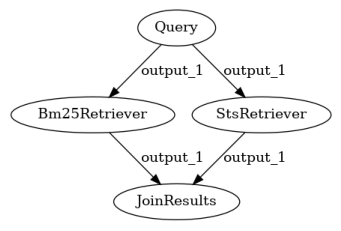

In [ ]:
util_pipeline.imprime_pipe(pipe_join_sts_multihop_bm25)

# Experiments

In [ ]:
# del pipes[1]

In [46]:
pipes

[{'PIPE_NAME': 'pipe_bm25_ranker',
  'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f1ea346f510>,
  'RETRIEVER_TYPE': 'bm25',
  'RETRIEVER_MODEL_NAME': '',
  'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-indir-5200'}]

In [47]:
grid_experiment = { 'CRITERIA' : ["area", "theme", "subtheme", "extra", "total", "total_gte_5"],
     # 'CRITERIA' : ["area", "theme", "subtheme", "extra", "total"],
             'TOPK_RETRIEVER' : [300],
             'TOPK_RANKER' : [0],
             'PIPE': pipes,
             'DONE': [False]
}

In [48]:
list_experiment = [dict(zip(grid_experiment.keys(), values)) for values in product(*grid_experiment.values())]


In [49]:
print(len(list_experiment))
gc.collect()

6


92

In [50]:
importlib.reload(util_experiment)

<module 'util.util_experiment_juris_tcu_index' from '/home/borela/fontes/ind-ir/code/util/util_experiment_juris_tcu_index.py'>

In [51]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query = 100 #  9999999 # 100 # 
for cnt, experiment in enumerate(list_experiment):
    if not experiment['DONE']:
        list_result_experiment = [] # por experiment
        # no caso de normas segecex, bastaria 224 para qtd5 e 891 para qtd1
        print(f"==={cnt}/{len(list_experiment)}===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
        result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                parm_experiment=experiment,
                                                parm_ndcg_position=12,
                                                parm_limit_query=limit_query,
                                                parm_print=True)
        list_result_experiment.append(result_run)
        # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
        experiment['DONE'] = True
        util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu_index')



===0/6===>  2023-Jun-27 21:19:08 experiment: {'CRITERIA': 'area', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1ea346f510>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-indir-5200'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


RANK1_MEAN: 1.6
NDCG_MEAN: 85.662
TIME_SPENT_MEAN: 0.158
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
===1/6===>  2023-Jun-27 21:19:24 experiment: {'CRITERIA': 'theme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1ea346f510>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-indir-5200'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [05:57<00:00,  3.57s/it]


RANK1_MEAN: 5.854
NDCG_MEAN: 60.771
TIME_SPENT_MEAN: 3.573
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
===2/6===>  2023-Jun-27 21:25:23 experiment: {'CRITERIA': 'subtheme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1ea346f510>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-indir-5200'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


 32%|███▏      | 32/100 [01:22<02:54,  2.57s/it]

In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query = 100 #  9999999 # 100 # 
for cnt, experiment in enumerate(list_experiment):
    if not experiment['DONE']:
        list_result_experiment = [] # por experiment
        # no caso de normas segecex, bastaria 224 para qtd5 e 891 para qtd1
        print(f"==={cnt}/{len(list_experiment)}===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
        result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                parm_experiment=experiment,
                                                parm_ndcg_position=12,
                                                parm_limit_query=limit_query,
                                                parm_print=True)
        list_result_experiment.append(result_run)
        # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
        experiment['DONE'] = True
        util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu_index')



===0/6===>  2023-Jun-27 12:56:46 experiment: {'CRITERIA': 'area', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fbf26095ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-indir'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


RANK1_MEAN: 2.34
NDCG_MEAN: 74.187
TIME_SPENT_MEAN: 0.035
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
===1/6===>  2023-Jun-27 12:56:51 experiment: {'CRITERIA': 'theme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fbf26095ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-indir'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


RANK1_MEAN: 15.896
NDCG_MEAN: 48.585
TIME_SPENT_MEAN: 0.774
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
===2/6===>  2023-Jun-27 12:58:09 experiment: {'CRITERIA': 'subtheme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fbf26095ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-indir'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


RANK1_MEAN: 14.362
NDCG_MEAN: 29.203
TIME_SPENT_MEAN: 0.801
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 31
===3/6===>  2023-Jun-27 12:59:30 experiment: {'CRITERIA': 'extra', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fbf26095ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-indir'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


 14%|█▍        | 14/100 [00:12<01:14,  1.15it/s]


KeyboardInterrupt: 

In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query = 100 #  9999999 # 100 # 
for cnt, experiment in enumerate(list_experiment):
    if not experiment['DONE']:
        list_result_experiment = [] # por experiment
        # no caso de normas segecex, bastaria 224 para qtd5 e 891 para qtd1
        print(f"==={cnt}/{len(list_experiment)}===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
        result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                parm_experiment=experiment,
                                                parm_ndcg_position=12,
                                                parm_limit_query=limit_query,
                                                parm_print=True)
        list_result_experiment.append(result_run)
        # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
        experiment['DONE'] = True
        util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu_index')



===0/6===>  2023-Jun-27 08:15:48 experiment: {'CRITERIA': 'area', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fa376cc86d0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-49200'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


RANK1_MEAN: 2.34
NDCG_MEAN: 74.187
TIME_SPENT_MEAN: 0.035
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
===1/6===>  2023-Jun-27 08:15:53 experiment: {'CRITERIA': 'theme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fa376cc86d0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-49200'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


RANK1_MEAN: 15.896
NDCG_MEAN: 48.585
TIME_SPENT_MEAN: 0.775
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
===2/6===>  2023-Jun-27 08:17:11 experiment: {'CRITERIA': 'subtheme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fa376cc86d0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-49200'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


RANK1_MEAN: 14.362
NDCG_MEAN: 29.203
TIME_SPENT_MEAN: 0.799
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 31
===3/6===>  2023-Jun-27 08:18:32 experiment: {'CRITERIA': 'extra', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fa376cc86d0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-49200'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


RANK1_MEAN: 6.453
NDCG_MEAN: 33.854
TIME_SPENT_MEAN: 0.809
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 14
===4/6===>  2023-Jun-27 08:19:53 experiment: {'CRITERIA': 'total', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fa376cc86d0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-49200'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


RANK1_MEAN: 2.364
NDCG_MEAN: 43.711
TIME_SPENT_MEAN: 0.805
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
===5/6===>  2023-Jun-27 08:21:15 experiment: {'CRITERIA': 'total_gte_5', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fa376cc86d0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/mMiniLM-L6-v2-pt-v2-49200'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


RANK1_MEAN: 2.455
NDCG_MEAN: 43.492
TIME_SPENT_MEAN: 0.806
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
CPU times: user 7min 30s, sys: 2.24 s, total: 7min 33s
Wall time: 6min 48s


mt5-3B + join só para total_gt5

In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query = 100 #  9999999 # 100 # 
for cnt, experiment in enumerate(list_experiment):
    if not experiment['DONE']:
        list_result_experiment = [] # por experiment
        # no caso de normas segecex, bastaria 224 para qtd5 e 891 para qtd1
        print(f"==={cnt}/{len(list_experiment)}===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
        result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                parm_experiment=experiment,
                                                parm_ndcg_position=12,
                                                parm_limit_query=limit_query,
                                                parm_print=True)
        list_result_experiment.append(result_run)
        # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
        experiment['DONE'] = True
        util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu_index')



===0/18===>  2023-Jun-25 11:47:44 experiment: {'CRITERIA': 'area', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_join_bm25_sts_reranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a672ed0>, 'RETRIEVER_TYPE': 'join_sts_bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [00:13<00:00,  7.46it/s]


RANK1_MEAN: 1.54
NDCG_MEAN: 86.214
TIME_SPENT_MEAN: 0.134
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
===1/18===>  2023-Jun-25 11:47:58 experiment: {'CRITERIA': 'area', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a105ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [00:11<00:00,  9.05it/s]


RANK1_MEAN: 1.54
NDCG_MEAN: 86.214
TIME_SPENT_MEAN: 0.11
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
===2/18===>  2023-Jun-25 11:48:10 experiment: {'CRITERIA': 'area', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_sts_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd3619278d0>, 'RETRIEVER_TYPE': 'sts', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


RANK1_MEAN: 1.54
NDCG_MEAN: 86.214
TIME_SPENT_MEAN: 0.127
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
===3/18===>  2023-Jun-25 11:48:23 experiment: {'CRITERIA': 'theme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_join_bm25_sts_reranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a672ed0>, 'RETRIEVER_TYPE': 'join_sts_bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


RANK1_MEAN: 18.76
NDCG_MEAN: 28.968
TIME_SPENT_MEAN: 1.992
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
===4/18===>  2023-Jun-25 11:51:43 experiment: {'CRITERIA': 'theme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a105ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:15<00:00,  2.55s/it]


RANK1_MEAN: 31.052
NDCG_MEAN: 22.649
TIME_SPENT_MEAN: 2.553
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
===5/18===>  2023-Jun-25 11:55:59 experiment: {'CRITERIA': 'theme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_sts_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd3619278d0>, 'RETRIEVER_TYPE': 'sts', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:16<00:00,  2.56s/it]


RANK1_MEAN: 33.969
NDCG_MEAN: 19.691
TIME_SPENT_MEAN: 2.563
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
===6/18===>  2023-Jun-25 12:00:16 experiment: {'CRITERIA': 'subtheme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_join_bm25_sts_reranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a672ed0>, 'RETRIEVER_TYPE': 'join_sts_bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]


RANK1_MEAN: 21.775
NDCG_MEAN: 16.606
TIME_SPENT_MEAN: 2.102
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 29
===7/18===>  2023-Jun-25 12:03:47 experiment: {'CRITERIA': 'subtheme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a105ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:17<00:00,  2.57s/it]


RANK1_MEAN: 24.087
NDCG_MEAN: 15.02
TIME_SPENT_MEAN: 2.571
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 31
===8/18===>  2023-Jun-25 12:08:05 experiment: {'CRITERIA': 'subtheme', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_sts_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd3619278d0>, 'RETRIEVER_TYPE': 'sts', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


RANK1_MEAN: 36.905
NDCG_MEAN: 7.937
TIME_SPENT_MEAN: 2.425
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 26
===9/18===>  2023-Jun-25 12:12:08 experiment: {'CRITERIA': 'extra', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_join_bm25_sts_reranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a672ed0>, 'RETRIEVER_TYPE': 'join_sts_bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [03:46<00:00,  2.26s/it]


RANK1_MEAN: 15.157
NDCG_MEAN: 19.1
TIME_SPENT_MEAN: 2.26
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 17
===10/18===>  2023-Jun-25 12:15:54 experiment: {'CRITERIA': 'extra', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a105ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


RANK1_MEAN: 16.547
NDCG_MEAN: 17.664
TIME_SPENT_MEAN: 2.625
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 14
===11/18===>  2023-Jun-25 12:20:18 experiment: {'CRITERIA': 'extra', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_sts_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd3619278d0>, 'RETRIEVER_TYPE': 'sts', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:03<00:00,  2.43s/it]


RANK1_MEAN: 23.722
NDCG_MEAN: 11.797
TIME_SPENT_MEAN: 2.431
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 21
===12/18===>  2023-Jun-25 12:24:21 experiment: {'CRITERIA': 'total', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_join_bm25_sts_reranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a672ed0>, 'RETRIEVER_TYPE': 'join_sts_bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [03:46<00:00,  2.27s/it]


RANK1_MEAN: 3.212
NDCG_MEAN: 40.503
TIME_SPENT_MEAN: 2.266
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
===13/18===>  2023-Jun-25 12:28:08 experiment: {'CRITERIA': 'total', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a105ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:25<00:00,  2.65s/it]


RANK1_MEAN: 5.273
NDCG_MEAN: 36.22
TIME_SPENT_MEAN: 2.654
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
===14/18===>  2023-Jun-25 12:32:35 experiment: {'CRITERIA': 'total', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_sts_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd3619278d0>, 'RETRIEVER_TYPE': 'sts', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


RANK1_MEAN: 5.89
NDCG_MEAN: 27.996
TIME_SPENT_MEAN: 2.442
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
===15/18===>  2023-Jun-25 12:36:39 experiment: {'CRITERIA': 'total_gte_5', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_join_bm25_sts_reranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a672ed0>, 'RETRIEVER_TYPE': 'join_sts_bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [03:42<00:00,  2.23s/it]


RANK1_MEAN: 4.707
NDCG_MEAN: 33.0
TIME_SPENT_MEAN: 2.228
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
===16/18===>  2023-Jun-25 12:40:23 experiment: {'CRITERIA': 'total_gte_5', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd36a105ad0>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:26<00:00,  2.66s/it]


RANK1_MEAN: 6.02
NDCG_MEAN: 30.353
TIME_SPENT_MEAN: 2.663
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
===17/18===>  2023-Jun-25 12:44:50 experiment: {'CRITERIA': 'total_gte_5', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_sts_ranker', 'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fd3619278d0>, 'RETRIEVER_TYPE': 'sts', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': 'unicamp-dl/ptt5-base-pt-msmarco-100k-v2-7600'}, 'DONE': False}
Experimento envolverá 100 registros, queries selecionadas para validação


100%|██████████| 100/100 [04:09<00:00,  2.50s/it]


RANK1_MEAN: 7.85
NDCG_MEAN: 22.708
TIME_SPENT_MEAN: 2.498
COUNT_QUERY_RUN: 100
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
CPU times: user 58min 8s, sys: 1.06 s, total: 58min 9s
Wall time: 1h 1min 15s


Free resources: 

In [ ]:
quit()

: 